#Fetching,Loading and Plotting the Dataset



In [1]:
#Download the dataset from the kaggle
!curl -L -o ./archive.zip https://www.kaggle.com/api/v1/datasets/download/sandeepkapri/banknifty-data-upto-2024
!unzip archive.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 14.8M  100 14.8M    0     0  17.8M      0 --:--:-- --:--:-- --:--:--  280M
Archive:  archive.zip
  inflating: LICENSE                 
  inflating: README.md               
  inflating: bank-nifty-15m-data.csv  
  inflating: bank-nifty-1d-data.csv  
  inflating: bank-nifty-1h-data.csv  
  inflating: bank-nifty-1m-data.csv  
  inflating: bank-nifty-2h-data.csv  
  inflating: bank-nifty-3h-data.csv  
  inflating: bank-nifty-5m-data.csv  


In [8]:
#importing the dataset and removing other columns
import pandas as pd

df = pd.read_csv("/content/bank-nifty-5m-data.csv")
df.head()

,Instrument,Date,Time,Open,High,Low,Close
0,Banknifty,09-01-2015,9:15:00,18845.90,18864.00,18790.20,18849.25
1,Banknifty,09-01-2015,9:20:00,18849.25,18859.65,18829.80,18847.00
2,Banknifty,09-01-2015,9:25:00,18847.00,18850.15,18799.40,18815.15
3,Banknifty,09-01-2015,9:30:00,18815.15,18821.40,18772.90,18810.70
4,Banknifty,09-01-2015,9:35:00,18810.70,18811.95,18788.55,18800.05


In [9]:
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)
df = df[["Datetime","Close"]]
df_temp = df.copy()
df_temp.set_index("Datetime",inplace=True)
df.head()

,Datetime,Close
0,2015-01-09 09:15:00,18849.25
1,2015-01-09 09:20:00,18847.00
2,2015-01-09 09:25:00,18815.15
3,2015-01-09 09:30:00,18810.70
4,2015-01-09 09:35:00,18800.05


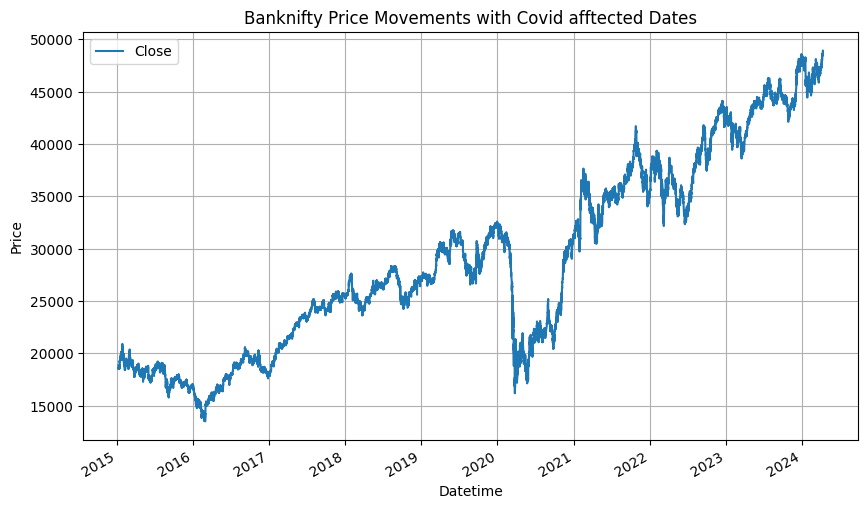

In [10]:
import matplotlib.pyplot as plt


df_temp[['Close']].plot(figsize=(10, 6), title='Banknifty Price Movements with Covid afftected Dates')
plt.xlabel('Datetime')
plt.ylabel('Price')
plt.grid()
plt.show()

#Filtering the COVID-affected dates by identifying the start and end dates of the COVID period and retaining only the data within that timeframe.

In [11]:
#filtering covid affected dates covid initial and ending and keeping the in between dates
#considering those dates as outliers

start_date1 = pd.to_datetime('2020-02-22 09:15:00')
end_date1 = pd.to_datetime('2020-03-23 09:30:00')

start_date2 = pd.to_datetime('2020-11-02 09:15:00')
end_date2 = pd.to_datetime('2020-11-24 09:30:00')

mask1 = (df['Datetime'] >= start_date1) & (df['Datetime'] <= end_date1)
mask2 = (df['Datetime'] >= start_date2) & (df['Datetime'] <= end_date2)
mask = mask1 | mask2

new_df = df[~mask]

mask3 = (df['Datetime'] >= end_date1) & (df['Datetime'] <= start_date2)

new_df.loc[mask3, 'Close'] += 8000


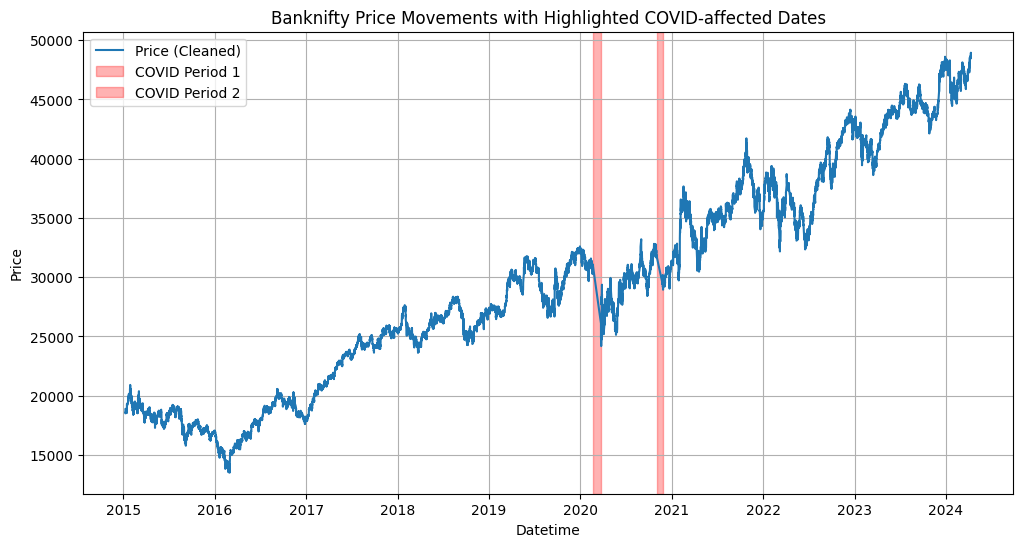

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(new_df['Datetime'], new_df['Close'], label='Price (Cleaned)')

plt.axvspan(start_date1, end_date1, color='red', alpha=0.3, label='COVID Period 1')
plt.axvspan(start_date2, end_date2, color='red', alpha=0.3, label='COVID Period 2')

plt.title('Banknifty Price Movements with Highlighted COVID-affected Dates')
plt.xlabel('Datetime')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

#Pre-Processing and Splitting Dataset

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam

data = new_df.copy()
data.set_index('Datetime', inplace=True)
close_prices = data['Close'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_data = scaler.fit_transform(close_prices)


In [7]:
#Splitting the dataset Train,Val,Test

import numpy as np

def create_dataset(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back, 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)


look_back = 50
X, y = create_dataset(normalized_data, look_back)
X = X.reshape(X.shape[0], X.shape[1], 1)


train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)
test_size = len(X) - train_size - val_size

X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]


print("Training set size: ", len(X_train), len(y_train))
print("Validation set size: ", len(X_val), len(y_val))
print("Testing set size: ", len(X_test), len(y_test))


Training set size:  117879 117879
Validation set size:  25259 25259
Testing set size:  25261 25261


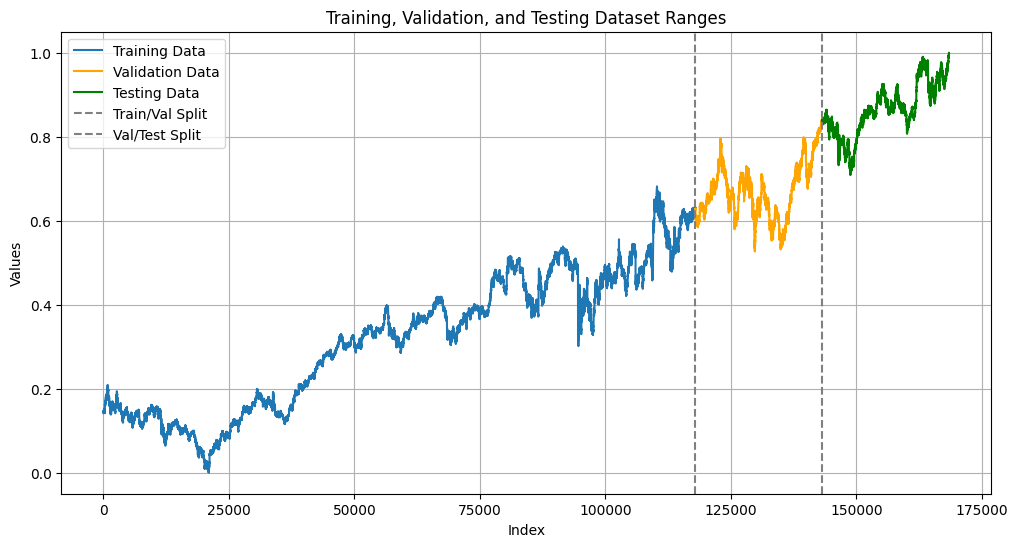

In [ ]:

train_range = range(look_back, look_back + len(y_train))
val_range = range(look_back + len(y_train), look_back + len(y_train) + len(y_val))
test_range = range(look_back + len(y_train) + len(y_val), look_back + len(y_train) + len(y_val) + len(y_test))

# Plot the ranges
plt.figure(figsize=(12, 6))
plt.plot(train_range, y_train, label="Training Data")
plt.plot(val_range, y_val, label="Validation Data", color="orange")
plt.plot(test_range, y_test, label="Testing Data", color="green")
plt.axvline(x=look_back + len(y_train), color='gray', linestyle='--', label="Train/Val Split")
plt.axvline(x=look_back + len(y_train) + len(y_val), color='gray', linestyle='--', label="Val/Test Split")
plt.title("Training, Validation, and Testing Dataset Ranges")
plt.xlabel("Index")
plt.ylabel("Values")
plt.legend()
plt.grid()
plt.show()


#Simple RNN Model - Training and Testing

In [8]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau


model = Sequential([
    SimpleRNN(128, activation='tanh', return_sequences=True, input_shape=(look_back, 1)),
    Dropout(0.2),
    SimpleRNN(64, activation='tanh', return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(1)
])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 50, 128)             │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 64)                  │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,105 (121.50 KB)

 Trainable params: 31,105 (121.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping,lr_scheduler])

model.save('/content/drive/My Drive/rnn_model.h5')

Epoch 1/40
3683/3683 ━━━━━━━━━━━━━━━━━━━━ 55s 14ms/step - loss: 0.0194 - val_loss: 0.0011 - learning_rate: 0.0010
Epoch 2/40
3683/3683 ━━━━━━━━━━━━━━━━━━━━ 76s 13ms/step - loss: 1.9134e-04 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 3/40
3683/3683 ━━━━━━━━━━━━━━━━━━━━ 81s 12ms/step - loss: 1.5897e-04 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 4/40
3683/3683 ━━━━━━━━━━━━━━━━━━━━ 81s 12ms/step - loss: 1.5289e-04 - val_loss: 5.1236e-04 - learning_rate: 0.0010
Epoch 5/40
3683/3683 ━━━━━━━━━━━━━━━━━━━━ 82s 12ms/step - loss: 1.4078e-04 - val_loss: 0.0011 - learning_rate: 0.0010
Epoch 6/40
3683/3683 ━━━━━━━━━━━━━━━━━━━━ 45s 12ms/step - loss: 1.2754e-04 - val_loss: 6.3634e-04 - learning_rate: 0.0010
Epoch 7/40
3683/3683 ━━━━━━━━━━━━━━━━━━━━ 82s 12ms/step - loss: 1.3098e-04 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 8/40
3683/3683 ━━━━━━━━━━━━━━━━━━━━ 82s 12ms/step - loss: 1.2540e-04 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 9/40
3681/3683 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/st

In [ ]:
from tensorflow.keras.models import load_model
model = load_model("/content/drive/My Drive/rnn_model.h5")

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_6 (SimpleRNN)             │ (None, 50, 128)             │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 50, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_7 (SimpleRNN)             │ (None, 50, 128)             │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 50, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_8 (SimpleRNN)             │ (None, 64)                  │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,003 (250.02 KB)

 Trainable params: 64,001 (250.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [ ]:
y_test_pred = model.predict(X_test, verbose=0)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
y_test_pred = scaler.inverse_transform(y_test_pred)

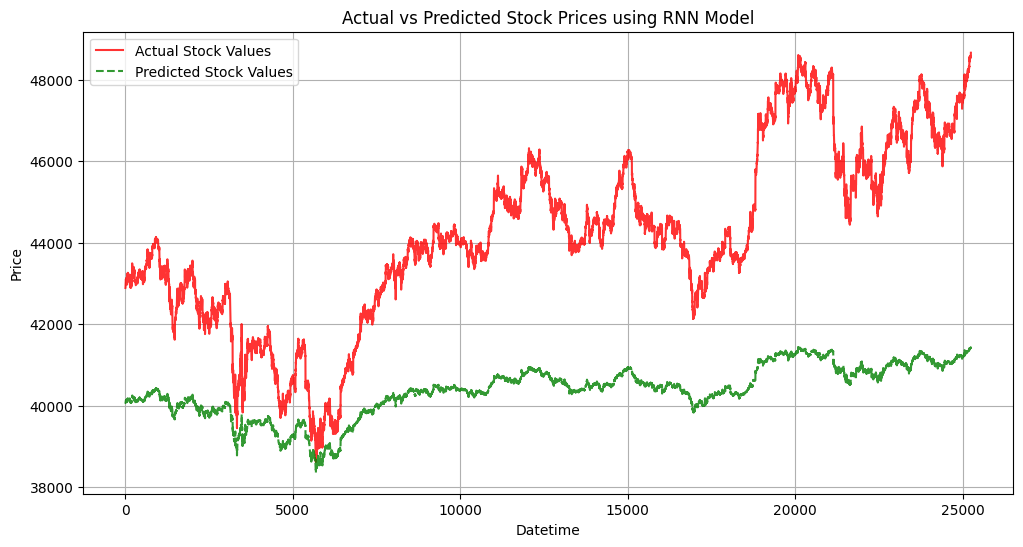

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test_actual)), y_test_actual, label='Actual Stock Values', alpha=0.8,color = "red")
plt.plot(range(len(y_test_pred)), y_test_pred, label='Predicted Stock Values', linestyle='--', alpha=0.8,color = "green")
plt.title("Actual vs Predicted Stock Prices using RNN Model")
plt.xlabel("Datetime")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()

In [ ]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.1 MB/s eta 0:00:00


## Hyper-parameter Tunning for RNN Model

In [ ]:
import keras_tuner as kt

# Define a function to build the model
def build_model(hp):
    model = Sequential()

    model.add(SimpleRNN(
        units=hp.Int('units_1', min_value=32, max_value=256, step=32),
        activation='tanh',
        return_sequences=True,
        input_shape=(look_back, 1)
    ))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(SimpleRNN(
        units=hp.Int('units_2', min_value=32, max_value=256, step=32),
        activation='tanh',
        return_sequences=False
    ))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('dense_units', min_value=16, max_value=128, step=16),
        activation='relu',
        kernel_regularizer=l2(hp.Float('l2', min_value=1e-5, max_value=1e-2, sampling='log'))
    ))
    model.add(Dense(1))


    lr = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    model.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')

    return model

tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=40,
    max_trials=30,
    factor=3,
    directory='my_dir',
    project_name='rnn_hyperparameter_tuning'
)

stop_early = EarlyStopping(monitor='val_loss', patience=10)
tuner.search(X_train, y_train, epochs=40, validation_data=(X_val, y_val), callbacks=[stop_early])

# Get the best hyperparameters and model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps.values}")

best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=40, callbacks=[stop_early])

#best_model.save('/content/drive/My Drive/best_rnn_model.h5')


Trial 46 Complete [00h 03m 36s]
val_loss: 0.0002591154770925641

Best val_loss So Far: 0.00016342609887942672
Total elapsed time: 02h 00m 06s

Search: Running Trial #47

Value             |Best Value So Far |Hyperparameter
96                |96                |units_1
0.4               |0.4               |dropout_1
192               |192               |units_2
0.3               |0.3               |dropout_2
96                |96                |dense_units
0.00018936        |0.00018936        |l2
0.00032062        |0.00032062        |learning_rate
14                |5                 |tuner/epochs
5                 |2                 |tuner/initial_epoch
3                 |3                 |tuner/bracket
2                 |1                 |tuner/round
0036              |0005              |tuner/trial_id

Epoch 6/14
3684/3684 ━━━━━━━━━━━━━━━━━━━━ 53s 13ms/step - loss: 1.2585e-04 - val_loss: 0.0011
Epoch 7/14
3684/3684 ━━━━━━━━━━━━━━━━━━━━ 78s 13ms/step - loss: 1.1432e-04 - val_loss: 

##Retraining the RNN model after finding best hyper parameter

In [9]:

model = Sequential([
    SimpleRNN(96, activation='tanh', return_sequences=True, input_shape=(look_back, 1)),
    Dropout(0.4),
    SimpleRNN(192, activation='tanh', return_sequences=False),
    Dropout(0.3),
    Dense(96, activation='relu', kernel_regularizer=l2(0.00018936)),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.00032062), loss='mean_squared_error')


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)


history = model.fit(
    X_train, y_train,
    epochs=14,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

Epoch 1/14
3684/3684 ━━━━━━━━━━━━━━━━━━━━ 54s 13ms/step - loss: 0.0205 - val_loss: 0.0018 - learning_rate: 3.2062e-04
Epoch 2/14
3684/3684 ━━━━━━━━━━━━━━━━━━━━ 47s 13ms/step - loss: 9.1969e-04 - val_loss: 3.6908e-04 - learning_rate: 3.2062e-04
Epoch 3/14
3684/3684 ━━━━━━━━━━━━━━━━━━━━ 81s 12ms/step - loss: 1.7960e-04 - val_loss: 0.0032 - learning_rate: 3.2062e-04
Epoch 4/14
3684/3684 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.2113e-04
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00016030999540816993.
3684/3684 ━━━━━━━━━━━━━━━━━━━━ 82s 12ms/step - loss: 1.2113e-04 - val_loss: 7.7138e-04 - learning_rate: 3.2062e-04
Epoch 5/14
3684/3684 ━━━━━━━━━━━━━━━━━━━━ 46s 12ms/step - loss: 8.4761e-05 - val_loss: 0.0014 - learning_rate: 1.6031e-04
Epoch 6/14
3681/3684 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.1029e-05
Epoch 6: ReduceLROnPlateau reducing learning rate to 8.015499770408496e-05.
3684/3684 ━━━━━━━━━━━━━━━━━━━━ 82s 12ms/step - loss: 8.1027e-05 - val_loss: 0.0011 - learning_ra

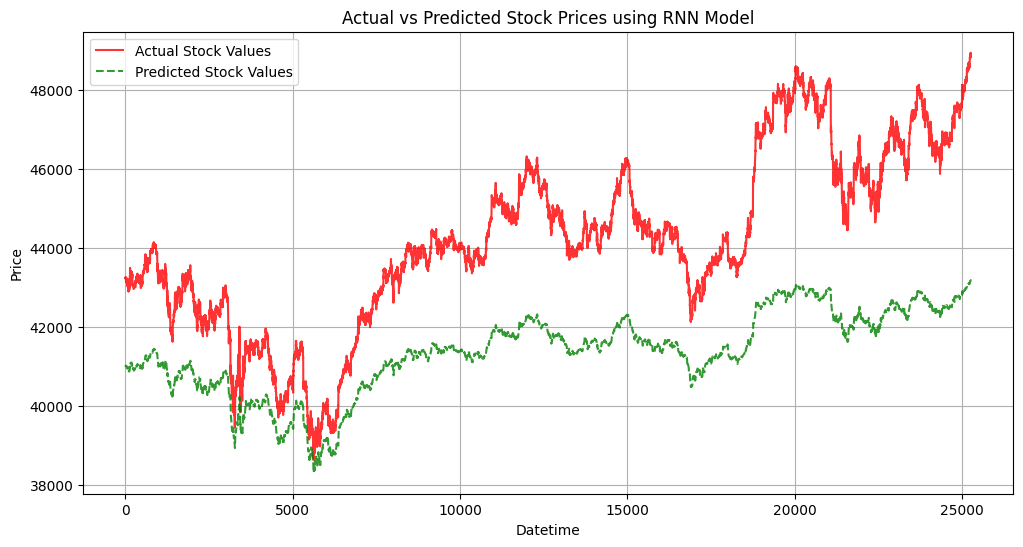

In [10]:
y_test_pred = model.predict(X_test, verbose=0)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
y_test_pred = scaler.inverse_transform(y_test_pred)

plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test_actual)), y_test_actual, label='Actual Stock Values', alpha=0.8,color = "red")
plt.plot(range(len(y_test_pred)), y_test_pred, label='Predicted Stock Values', linestyle='--', alpha=0.8,color = "green")ca
plt.title("Actual vs Predicted Stock Prices using RNN Model")
plt.xlabel("Datetime")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()

##LSTM Model - Training and Testing

In [ ]:
from tensorflow.keras.layers import LSTM

# Define the LSTM model
model = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(look_back, 1)),
    Dropout(0.2),
    LSTM(64, activation='tanh', return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(1)
])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 50, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 118,081 (461.25 KB)

 Trainable params: 118,081 (461.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stopping,lr_scheduler])

model.save('/content/drive/My Drive/lstm_model.h5')

Epoch 1/40
3683/3683 ━━━━━━━━━━━━━━━━━━━━ 47s 11ms/step - loss: 0.0073 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 2/40
3683/3683 ━━━━━━━━━━━━━━━━━━━━ 75s 10ms/step - loss: 1.5141e-04 - val_loss: 0.0072 - learning_rate: 0.0010
Epoch 3/40
3683/3683 ━━━━━━━━━━━━━━━━━━━━ 43s 11ms/step - loss: 1.4380e-04 - val_loss: 0.0080 - learning_rate: 0.0010
Epoch 4/40
3683/3683 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - loss: 1.2528e-04 - val_loss: 0.0078 - learning_rate: 0.0010
Epoch 5/40
3683/3683 ━━━━━━━━━━━━━━━━━━━━ 40s 10ms/step - loss: 1.2178e-04 - val_loss: 0.0039 - learning_rate: 0.0010
Epoch 6/40
3679/3683 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0569e-04
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
3683/3683 ━━━━━━━━━━━━━━━━━━━━ 39s 10ms/step - loss: 1.0569e-04 - val_loss: 0.0046 - learning_rate: 0.0010
Epoch 7/40
3683/3683 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - loss: 7.6585e-05 - val_loss: 0.0119 - learning_rate: 5.0000e-04
Epoch 8/40
3683/3683 ━━━━━━━━━━━━━━━

In [ ]:
model = load_model("/content/drive/My Drive/lstm_model.h5")

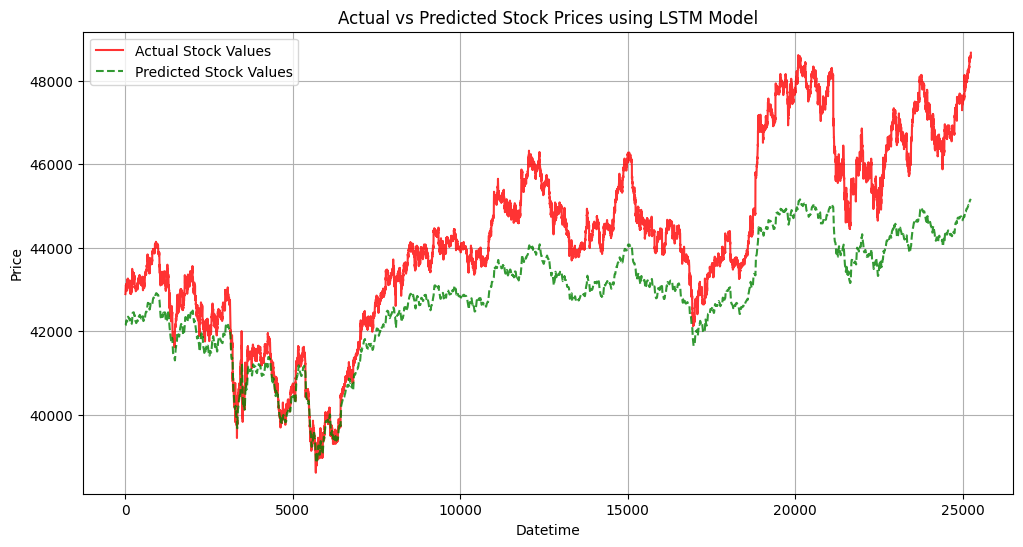

In [ ]:
y_test_pred = model.predict(X_test, verbose=0)

y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
y_test_pred = scaler.inverse_transform(y_test_pred)

plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test_actual)), y_test_actual, label='Actual Stock Values', alpha=0.8,color = "red")
plt.plot(range(len(y_test_pred)), y_test_pred, label='Predicted Stock Values', linestyle='--', alpha=0.8,color = "green")
plt.title("Actual vs Predicted Stock Prices using LSTM Model")
plt.xlabel("Datetime")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()

##GRU Model - Training and Testing

In [ ]:

from tensorflow.keras.layers import GRU

model = Sequential([
    GRU(128, activation='tanh', return_sequences=True, input_shape=(look_back, 1)),
    Dropout(0.2),
    GRU(64, activation='tanh', return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(1)
])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 50, 128)             │          50,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 50, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 64)                  │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 89,665 (350.25 KB)

 Trainable params: 89,665 (350.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stopping,lr_scheduler])

model.save('/content/drive/My Drive/gru_model.h5')

Epoch 1/40
3683/3683 ━━━━━━━━━━━━━━━━━━━━ 40s 10ms/step - loss: 0.0076 - val_loss: 2.4564e-04 - learning_rate: 0.0010
Epoch 2/40
3683/3683 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - loss: 1.4682e-04 - val_loss: 0.0023 - learning_rate: 0.0010
Epoch 3/40
3683/3683 ━━━━━━━━━━━━━━━━━━━━ 44s 11ms/step - loss: 1.3305e-04 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 4/40
3683/3683 ━━━━━━━━━━━━━━━━━━━━ 38s 10ms/step - loss: 1.1133e-04 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 5/40
3683/3683 ━━━━━━━━━━━━━━━━━━━━ 39s 10ms/step - loss: 1.0840e-04 - val_loss: 6.5147e-04 - learning_rate: 0.0010
Epoch 6/40
3681/3683 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0172e-04
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
3683/3683 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - loss: 1.0172e-04 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 7/40
3683/3683 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - loss: 7.5974e-05 - val_loss: 0.0135 - learning_rate: 5.0000e-04
Epoch 8/40
3683/3683 ━━━━━━━

In [ ]:
model = load_model("/content/drive/My Drive/gru_model.h5")

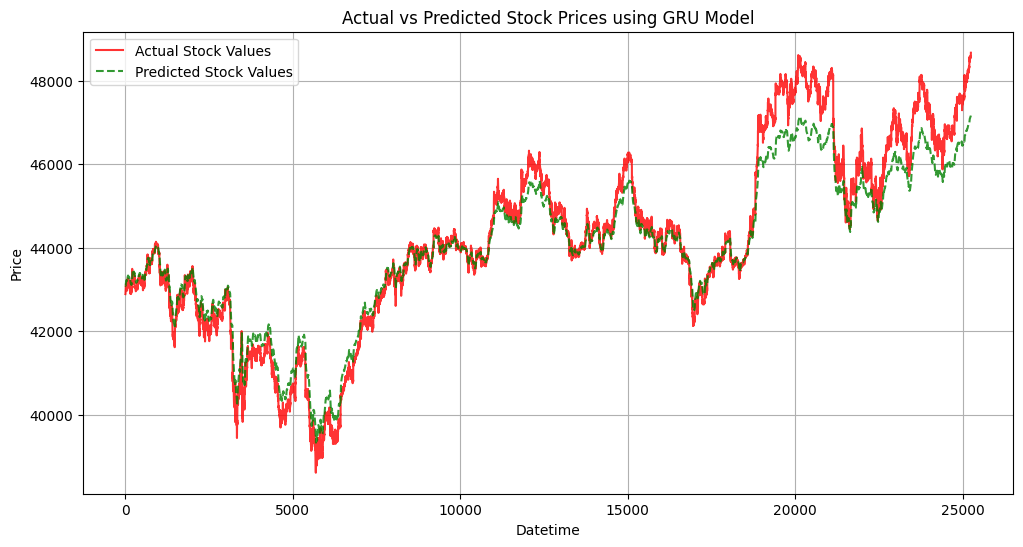

In [ ]:
y_test_pred = model.predict(X_test, verbose=0)

y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
y_test_pred = scaler.inverse_transform(y_test_pred)

plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test_actual)), y_test_actual, label='Actual Stock Values',  alpha=0.8,color = "red")
plt.plot(range(len(y_test_pred)), y_test_pred, label='Predicted Stock Values',  linestyle='--', alpha=0.8,color = "green")
plt.title("Actual vs Predicted Stock Prices using GRU Model")
plt.xlabel("Datetime")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()